In [16]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision
from scipy.stats import ttest_rel,ttest_ind

In [75]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None,plotres=False):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    if not plotres:
        return res
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
    resplot=np.around(res,3)
    for i in range(resplot.shape[0]):
        for j in range(resplot.shape[1]):
            text = ax.text(j, i, resplot[i, j],
                           ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res

In [66]:
modelname_all='resnet18'
plotsavepath_all=os.path.join('/data/xinyi/c2p/plots/',modelname_all)
names={'real protein':'conditionClf_origImg_sampling','full protein latent':'conditionClf_lord_p2p_fullrecon_sampling','shared protein latent':'conditionClf_lord_p2p_sharedRecon_sampling','predicted from chromatin':'conditionClf_lord_sampling'}
names_c={'real protein':'conditionClf_origImg_sampling','full protein latent':'conditionClf_c2c_fullrecon_sampling','shared protein latent':'conditionClf_c2c_sharedrecon_sampling','predicted from chromatin':'dne'}
proteins=np.array(['cd16','cd3','cd4','cd8','gh2ax','lamin','chromatin'])

### bar plot with error bars - protein

/data/xinyi/c2p/plots/resnet18/dne/chromatin/acc_val


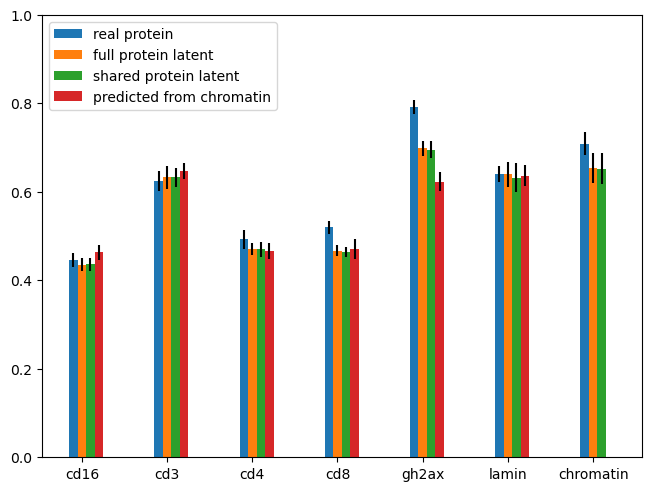

In [155]:
# more samples
x=np.arange(proteins.size)
width=0.1
multiplier=0

fig,ax=plt.subplots(layout='constrained')
for t in names.keys():
    offset=width*multiplier
    mean=np.zeros(proteins.size)
    std=np.zeros(proteins.size)
    for p_idx in range(proteins.size):
        p_curr=proteins[p_idx]
        
        if p_curr=='chromatin':
            plotsavepath_train_curr=os.path.join(plotsavepath_all,names_c[t],p_curr)
        else:
            plotsavepath_train_curr=os.path.join(plotsavepath_all,names[t],p_curr)
        if not os.path.exists(os.path.join(plotsavepath_train_curr,'acc_val')):
            print(os.path.join(plotsavepath_train_curr,'acc_val'))
            continue
        with open(os.path.join(plotsavepath_train_curr,'acc_val'), 'rb') as output:
            correctCount_val=pickle.load(output)
        if os.path.exists(os.path.join(plotsavepath_train_curr,'acc_val_moreSamples')):
            with open(os.path.join(plotsavepath_train_curr,'acc_val_moreSamples'), 'rb') as output:
                correctCount_val_moresamples=pickle.load(output)
            correctCount_val=np.concatenate((correctCount_val,correctCount_val_moresamples))
#             correctCount_val=correctCount_val_moresamples
        mean[p_idx]=np.mean(correctCount_val)
        std[p_idx]=np.std(correctCount_val)
    bars=ax.bar(x+offset,mean,width,label=t,yerr=std)
    multiplier+=1
ax.set_xticks(x+width,proteins)
ax.legend(loc='upper left')
ax.set_ylim(0,1)
plt.savefig(os.path.join(plotsavepath_all,'plots_conditionClf_sampling','accuracy_val_moreSamples.pdf'))

In [162]:
#pvalues of full vs shared
for p_idx in range(proteins.size):
    p_curr=proteins[p_idx]
    if p_curr=='chromatin':
        continue
    print(p_curr)
    plotsavepath_train_full=os.path.join(plotsavepath_all,names['full protein latent'],p_curr)
    plotsavepath_train_shared=os.path.join(plotsavepath_all,names['shared protein latent'],p_curr)
    with open(os.path.join(plotsavepath_train_full,'acc_val'), 'rb') as output:
        correctCount_val_full=pickle.load(output)
    with open(os.path.join(plotsavepath_train_shared,'acc_val'), 'rb') as output:
        correctCount_val_shared=pickle.load(output)
    with open(os.path.join(plotsavepath_train_full,'acc_val_moreSamples'), 'rb') as output:
        correctCount_val_full=np.concatenate((correctCount_val_full,pickle.load(output)))
    with open(os.path.join(plotsavepath_train_shared,'acc_val_moreSamples'), 'rb') as output:
        correctCount_val_shared=np.concatenate((correctCount_val_shared,pickle.load(output)))

    print(np.mean(correctCount_val_full-correctCount_val_shared))
    print(ttest_rel(correctCount_val_full,correctCount_val_shared,alternative='greater').pvalue)

cd16
-0.001056231095742874
0.7178003161411313
cd3
-0.00011518629941122854
0.514689958195441
cd4
0.0014088731240604784
0.20909975068798037
cd8
0.0018650545158362833
0.011481020190475118
gh2ax
0.0029973802758143995
0.0011932020617541816
lamin
0.0072611821331296615
0.09803243712184069
